## Trabajo Práctico Final
<br/>

## Curso de Especialización en Inteligencia Artificial
## Análisis de Series de Tiempo
<br/>

### Autor: Maximiliano Torti
### Fecha: 29/11/21
<br/>

1- Graficar una serie a partir de un dataset relevante. Explicar observaciones.

2- Descomponer una serie de tiempo usando el modelo aditivo y el modelo multiplicativo.

3- Aplicar los modelos vistos en clase:
- para la tendencia usar cuadrados mínimos y expresar los coeficientes. Sacar conclusiones acerca de la validez del modelo.
- componente cíclica: usar análisis espectral y hallar las frecuencias principales.
- para la componente estacional usar ARIMA.
- para la componente de error obtener R_k, C_k.


4- Predicciones:
- realizar predicciones usando (S)ARIMA
- realizar predicciones usando redes neuronales LSTM
- extraer conclusiones

--------------------------------------------------------------------------------------------------------------------------------
## Carga de librerías

In [1]:
# Importamos librerias
import pickle as pkl
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import curve_fit

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

--------------------------------------------------------------------------------------------------------------------------------
## Punto 1

In [2]:
# Carga de datos
path = './data/'

with open(path+ 'df_data_structured.pkl','rb') as file:
    df_x=pkl.load(file)

### Introducción
Este dataset fue creado y donado (públicamente) por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando ciclos de trabajo (se explicaran con detalle) sucesivos de 60 segundos de duración sobre un banco de pruebas de un circuito, midiendo las variables típicas de un procesos de este tipo (presiones, temperaturas, flujos) a la vez que se "variaba" la condición de sus componentes críticos. El objetivo de estos experimoentos era estudiar si es posible predecir, en base a las series de tiempo de las señales básicas, el estado de vida útil de los componentes críticos.

El banco consiste en un circuito primario de trabajo (donde circula el fluido por la máquina objetivo a lubricar o refrigerar), y un circuito secundario de enfriamiento para mantener el fluido en cierta temperatura. Los circuitos estan relacionados por un tanque común.
En la siguiente figura se puede observar el esquema de componentes.

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

El dataset posee la medición de 2205 ciclos de 17 señales. Cada ciclo posee 60, 600 o 6000 puntos dependiendo de la señal.

Las señales de proceso medidas son:
- 6 presiones de diferentes zonas. PS1-PS6
- Potencia de bomba principal. EPS1
- Flujo de circuito primario y secundario. FS1 y FS2
- 4 temperaturas de diferentes zonas. TS1 - TS4
- Vibraciones de la bomba principal. VS1
- Eficiencia de enfriamiento. CE
- Potencia de enfriamiento. CP
- Factor de eficiencia. SE

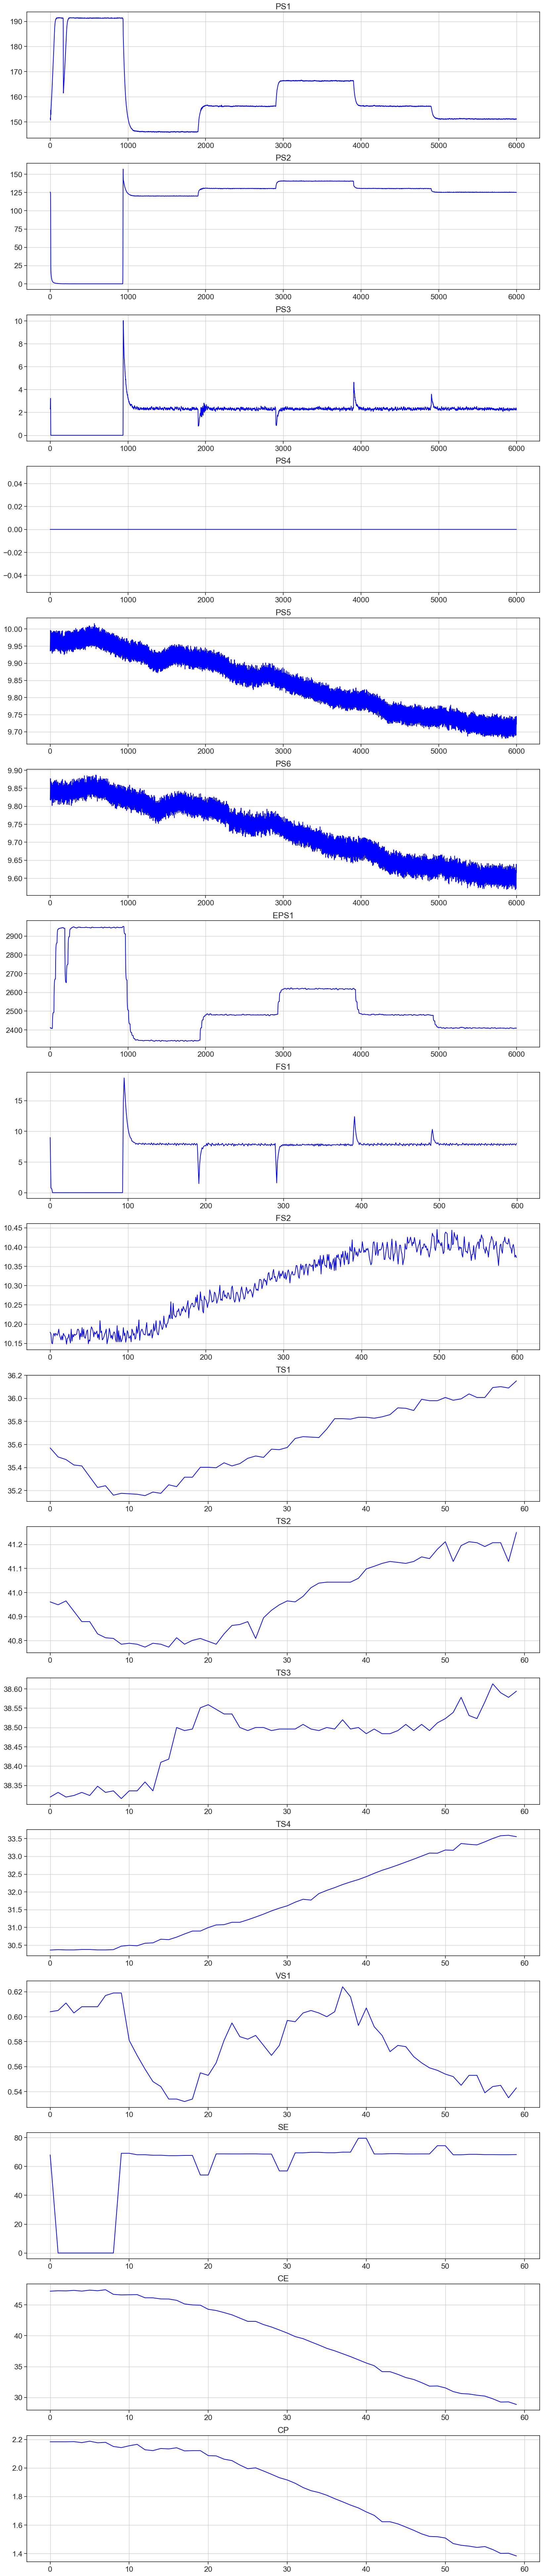

In [3]:
# Grafico de señales en un solo cicloa
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid(True)
plt.show()

**Breve explicación de las gráficas**

El ciclo de trabajo comienza en el instante 0 donde se aplica energía a la bomba MP1 (EPS1) para inyectar fluido por el circuito primario . Al estar la valvula V10 cerrada, se eleva la presión PS1 (previa a la válvula) sin elevar la presión PS2. Una vez alcanzada la presión de trabajo(en el instante 1000 aproximadamente), se abre la válvula V10 lo cual eleva la presión PS2 y disminuye PS1. A partir de este punto el fluido pasa por la máquina destino, intentando mantener el flujo (FS1) y la presión PS3 aproximadamente constante.  

Una vez que abre la válvula V10, el aceite comienza a calentarse (TS1 y TS2). En estas condiciones, el circuito secundario toma liquido del tanque y lo circula por un enfriador que desciende la temperatura de TS3 a TS4.

### Análisis

Se observa que estamos antes una serie de tiempo multivariada, donde el proceso depende de múltiples variables como presiones, temperaturas, potencias, etc. Dada la complejidad y el tamaño del dataset, este trabajo se centrará en el estudio únicamente de una de las variable mas importantes: PS1. Comenzamos graficando PS1 como un trend completo y como ciclos separados superpuestos:

In [4]:
serie = df_x['PS1']
x_serie = np.arange(0,serie.shape[1]*0.01,0.01, dtype=np.float64)
serie_1d = serie.reshape(-1,1)[:,0]
x_serie_1d= np.arange(0,serie_1d.size*0.01,0.01, dtype=np.float64)

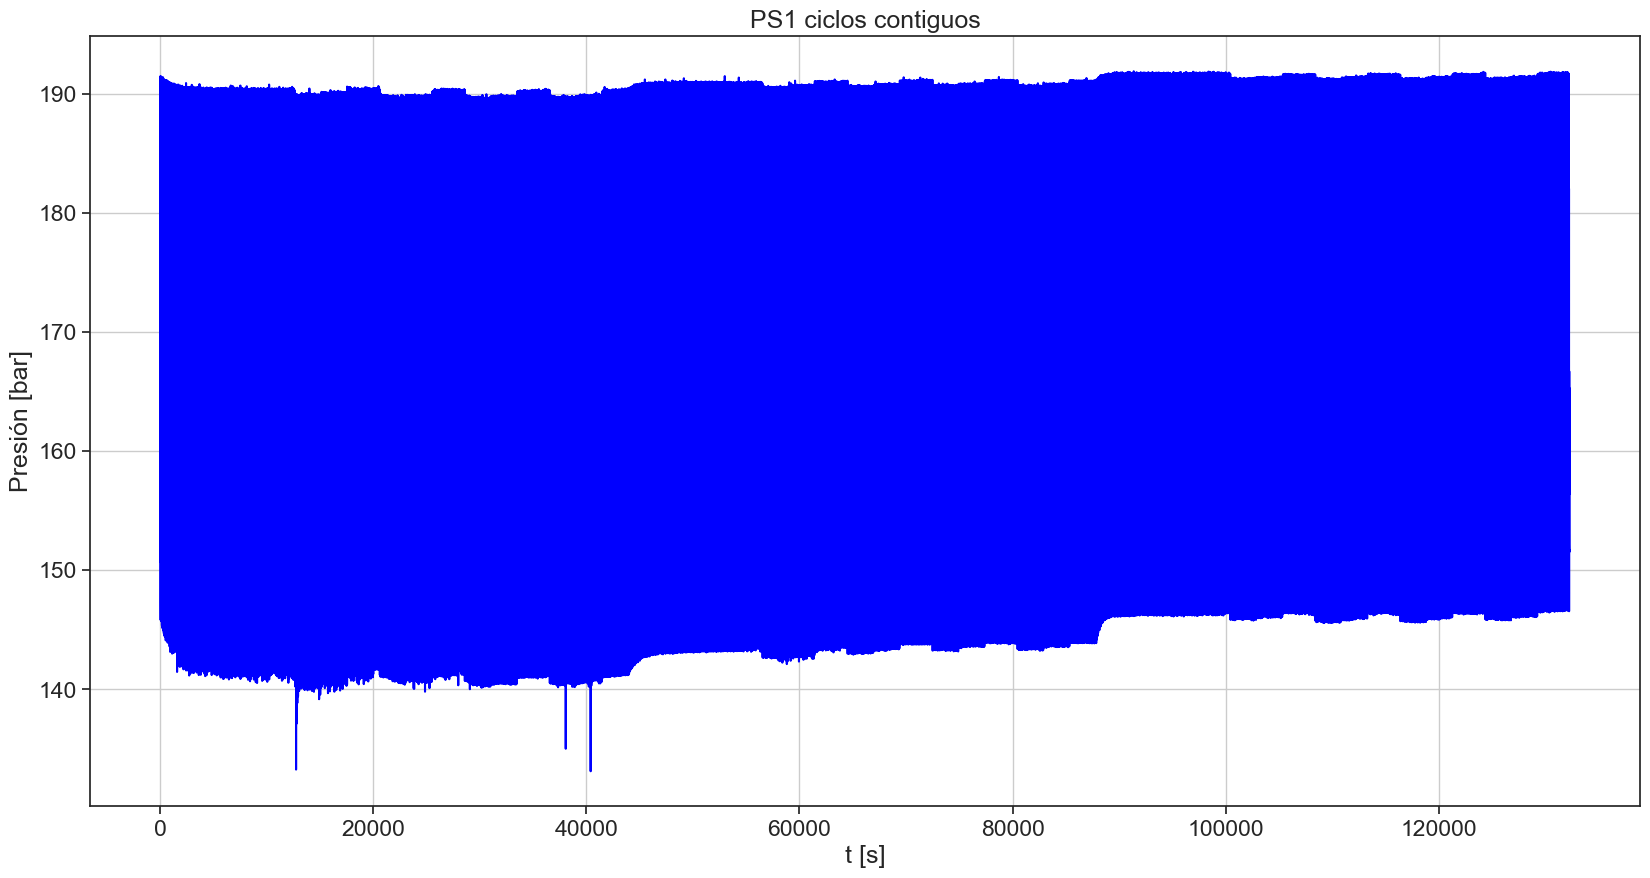

In [5]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d,serie_1d,color='blue')
ax.set_title("PS1 ciclos contiguos")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

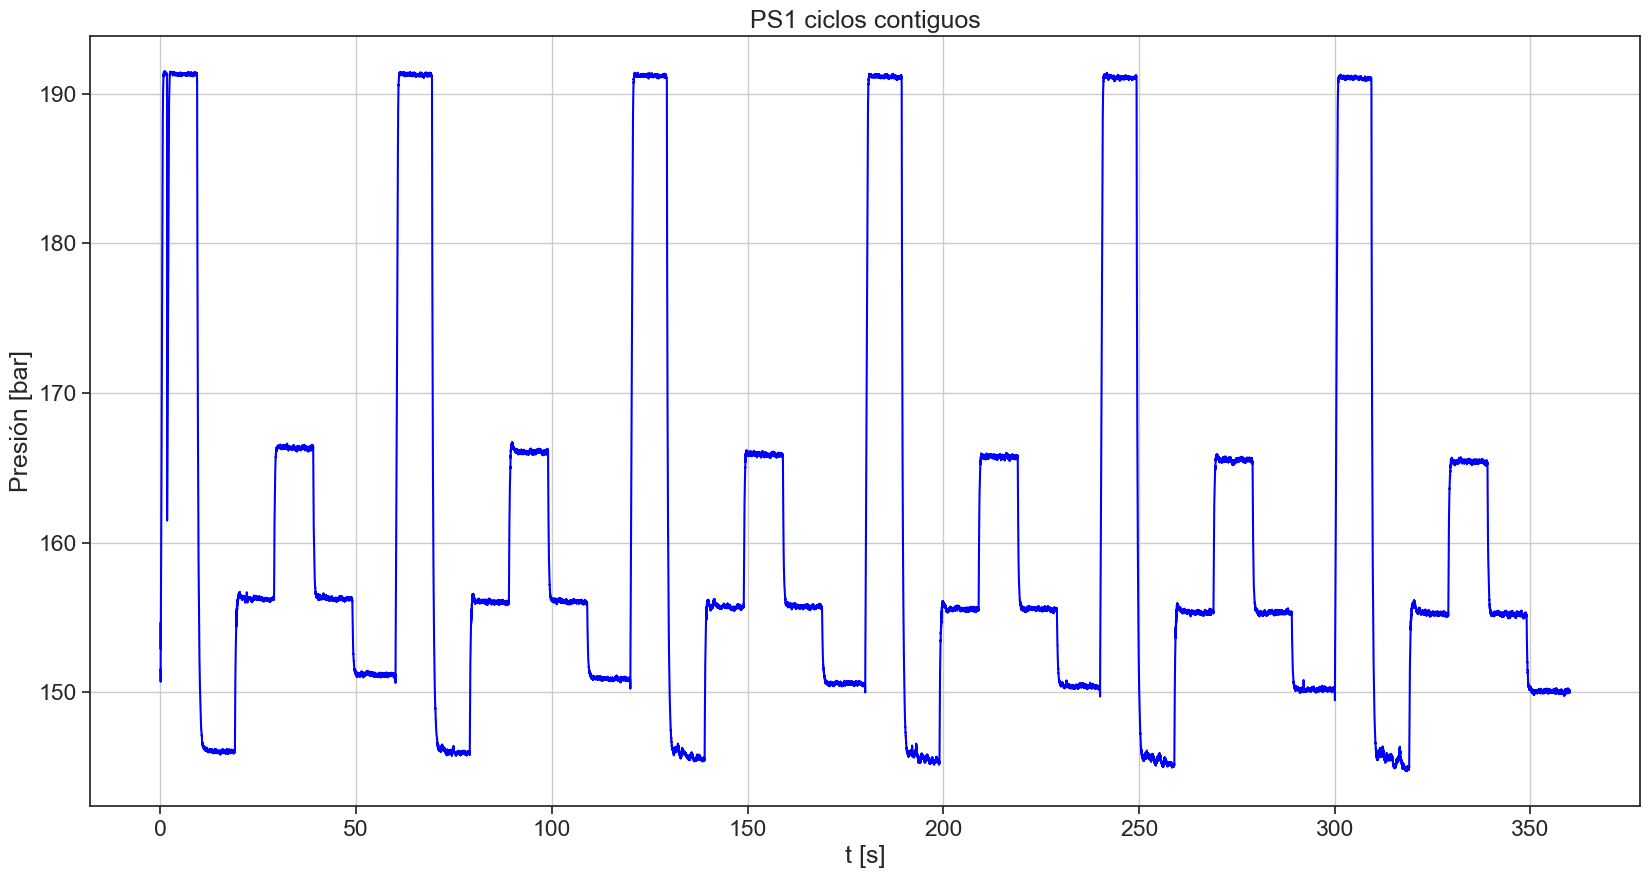

In [6]:
# Vista con mayor detalle
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d[0:36000],serie_1d[0:36000],color='blue')
ax.set_title("PS1 ciclos contiguos")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

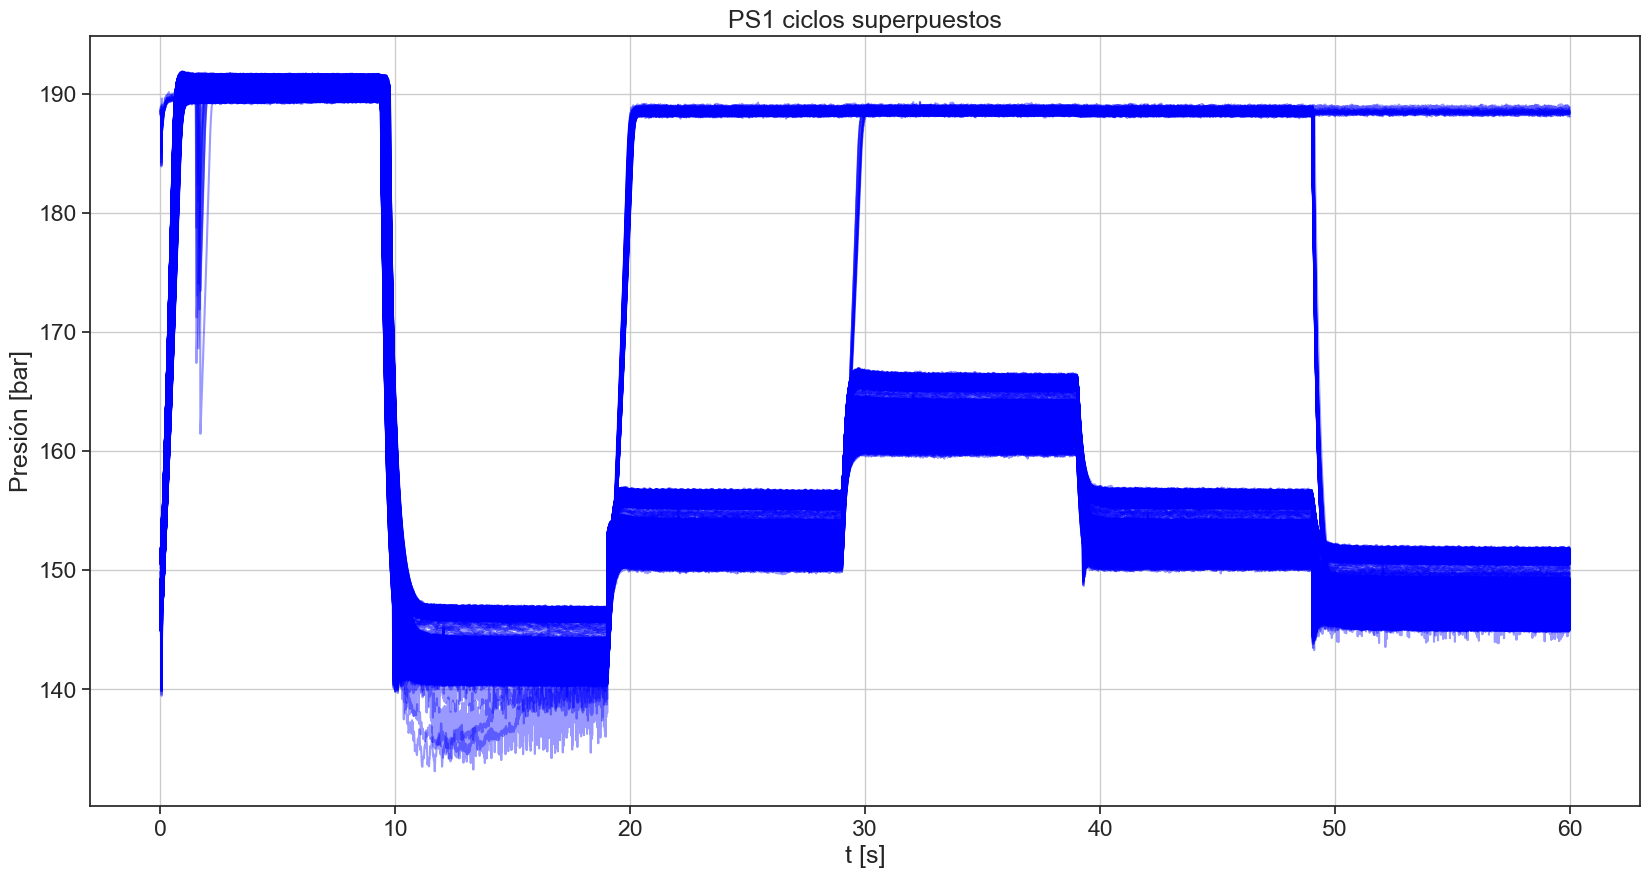

In [7]:
fig, ax = plt.subplots(1,figsize=(20, 10))
for i in range(serie.shape[0]):
    ax.plot(x_serie,serie[i],color='blue',label=None, alpha = 0.4)
ax.set_title("PS1 ciclos superpuestos")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

Tal como se mencionó anteriormente, la serie comienza en una presión alrededor de los 140 bar, luego se eleva a 190 bar y se mantiene por unos segundos en ese valor hasta los 10 segundos, donde se abre la válvula de circulación que genera una caída de presión instantánea. A partir de este momento, la presión crece y luego decrece escalonadamente cada 10 segundos aproximadamente. Este crecimiento y decrecimiento son generados para poder mantener un flujo constante de aceite sobre el circuito a medida que el proceso evoluciona. 

Desde un punto de vista estadístico, la serie es marcadamente no estacionaria. Ya a simple vista se observa que la media no es constante en el tiempo. Podemos decir que tiene una fuerte componente estacional con un ciclo de 60 segundos (6000 puntos), y de la primer gráfica también se aprecia una posible tendencia leve, ya que la presión mínima y máxima de cada ciclo paracen crecer conforme pasa el tiempo. 

Por último se identifican algunos puntos outliers cercanos al instante inicial, y algunos ciclos con evolución marcadamente diferente a la media a partir de los 18-19 segundos.

--------------------------------------------------------------------------------------------------------------------------------
## Punto 2 y 3

### Modelo aditivo

Se intentará descomponer la serie de tiempo en un modelo estacional aditivo, dado por:

Yt = Tt + St + Ct + et

Con:
- Tt: tendencia.
- St: variación estacional.
- Ct: Componente cíclico.
- et: Componente aleatoria.

Empezando con la tendencia, se presupone que la tendencia tiene una forma lineal Tt=a*t+b. Se estimará esta tendencia con cuadrados mínimos.

Se demuestra que para tendencia lineal, la solución por CM resulta:

In [8]:
def objective(t,a,b):
    return a*t+b

popt, _ = curve_fit(objective, x_serie_1d[::10], serie_1d[::10])
a,b = popt

In [9]:
a

-2.6092730836354268e-06

In [10]:
b

160.65870718335103

In [11]:
y_line = objective(x_serie_1d[::10],a,b)

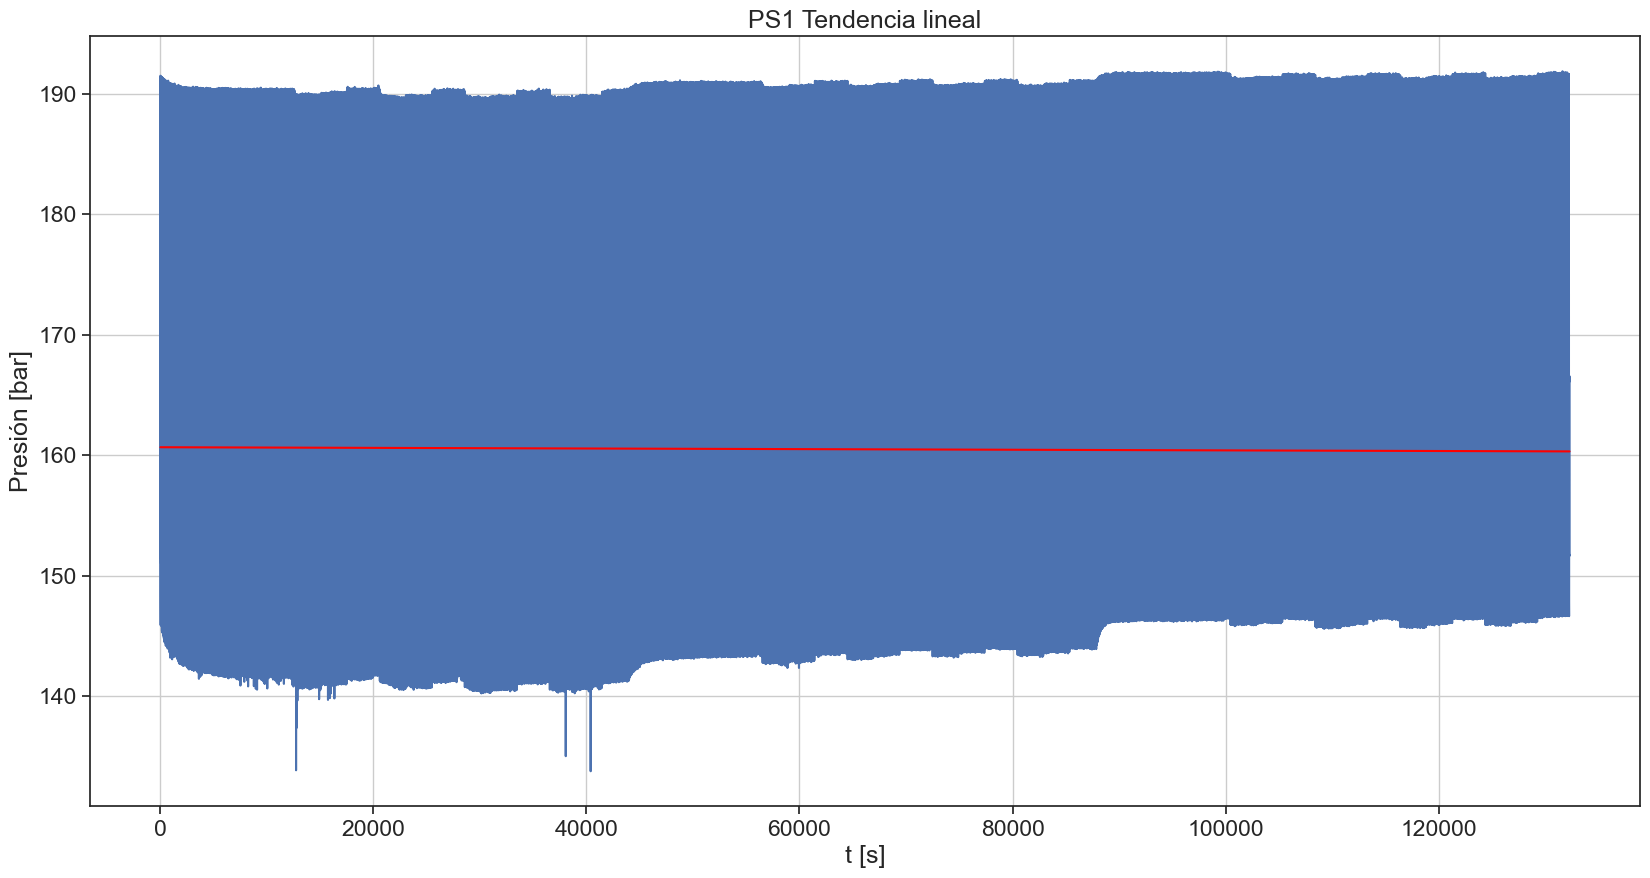

In [12]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d[::10], serie_1d[::10])
ax.plot(x_serie_1d[::10],y_line, color = 'red')
ax.set_title("PS1 Tendencia lineal")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

Se supuso que la tendencia era una lineal creciente, pero la pendiente resultante (parámetro a) resultó -2.6. De esto se puede concluir que quizá la tendencia sea únicamente una constante. Replanteamos el modelo como Tt=b

In [13]:
def objective(t,b):
    return b

popt, _ = curve_fit(objective, x_serie_1d[::10], serie_1d[::10])
Tt = popt

In [14]:
Tt

array([160.4861039])

# CONCLUSIONES VALIDEZ DEL MODELO??? VER DIAPOSITIVA 17

Para la componente ciclica, utilizaremos dos enfoques: por un lado fourier y por el otro considerar la componente ciclica como un conjunto de parámetros que se repiten cada T muestras (con T=ciclo).

En este caso, por la construcción del dataset, se conoce que el ciclo es de 60 segundos (6000 muestras).

In [15]:
# Componente ciclica 
Ct_1 = np.mean(serie-Tt,axis=0)

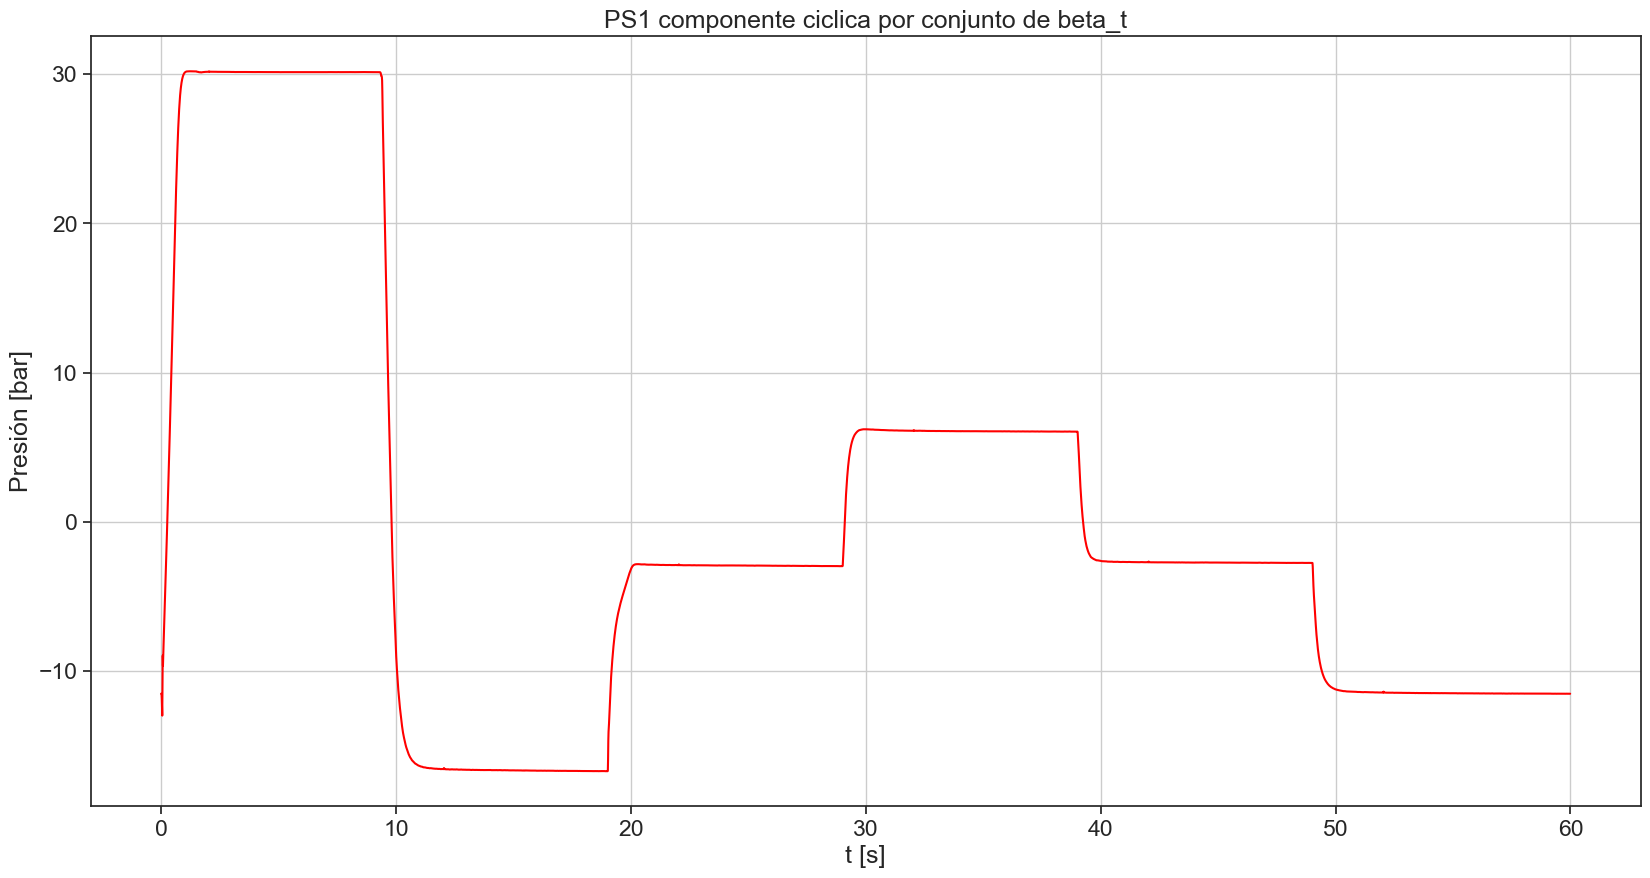

In [18]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie,Ct_1, color = 'red')
ax.set_title("PS1 componente ciclica por conjunto de beta_t")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

In [19]:
Ct_1 = np.tile(Ct_1,serie.shape[0])

Para la componente estacional, quitaremos los terminos de tendencia y cíclicos y aproximaremos por un modelo ARIMA

In [20]:
St_1 = (serie_1d - Ct_1) - Tt

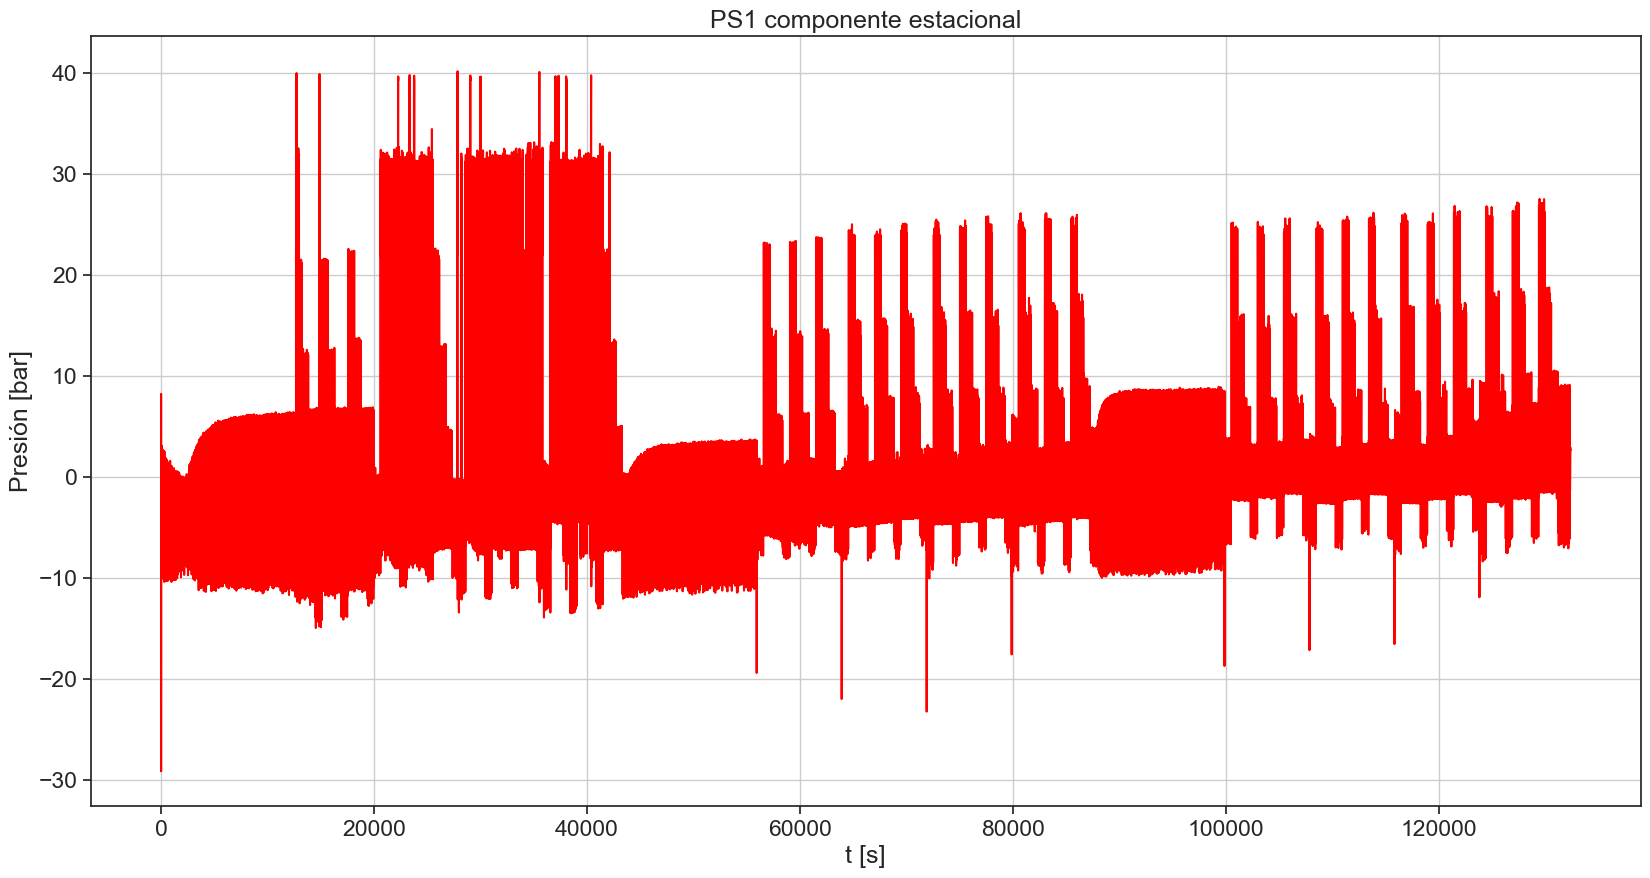

In [21]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x_serie_1d,St_1, color = 'red')
ax.set_title("PS1 componente estacional")
ax.set_xlabel("t [s]")
ax.set_ylabel("Presión [bar]")
ax.grid(True)
plt.show()

Observamos que en este caso no tenemos un modelo estacionario, por lo que aplicar ARIMA no resultaría del todo válido. Veamos la autocorrelación

In [ ]:
plot_acf(St_1,lags= np.arange(10))